# Universes

A universe is a collection of cells that can be used as a repeatable unit in the geometry. At a minimum, there must be one "root" universe (say, named `root`), which gets passed to `openmc.Geometry(root)`. But you can also use universes to repeat a collection of cells multiple times throughout a geometry. Here, we will explore some basic features of universes.

We'll start by making a universe which looks similar to the pincell we built earlier - say, a cylinder of UO2 enclosed by an infinite region of water. First, we set up our materials and create our geometry.

In [2]:
import openmc

In [6]:
uo2 = openmc.Material()
uo2.add_element('U', 1.0, enrichment=4.0)
uo2.add_element('O', 2.0)
uo2.set_density('g/cc', 11.0)

water = openmc.Material()
water.add_element('H', 2.0)
water.add_element('O', 1.0)
water.set_density('g/cc', 1.0)

materials = openmc.Materials()
materials.append(uo2)
materials.append(water)
materials.export_to_xml()

We have created a universe containing a pin, enclosed in an infinite medium of water. Now let's suppose that I want to fill this universe into an enclosing cell, a cylinder of radius 5 cm. Let's first create this cylinder, and then we will fill it with our `universe`.

Let's take a look at our geometry. In order to visualize at this stage, we need to create a universe from our `big_cell`.

We can see that our `big_cell`, the large cylinder, has been filled with the `universe` we declared earlier. Let's increase the complexity a bit to understand how this filling works. What if the cylinder of UO2 in our `universe` is not located at the origin, but is instead shifted to a different position?

We see that when we fill a universe inside of another cell, that there's (by default) no transformation of coordinates. You can shift the position of the universe filling a cell with the `Cell.translation` attribute. There are similar adjustments you can make, like rotations.

# Lattices

Lattices are a convenient way to (i) repeat a universe multiple times in space, while (ii) automatically translating that universe's origin to different positions in space.

In [25]:
import numpy as np
from IPython.display import Image

In this section, we will build one of the assemblies from the BEAVRS benchmark.  This is a PWR assembly with fuel pins, guide tubes, and borosilicate glass burnable poisons.  A diagram of the assembly is plotted below.

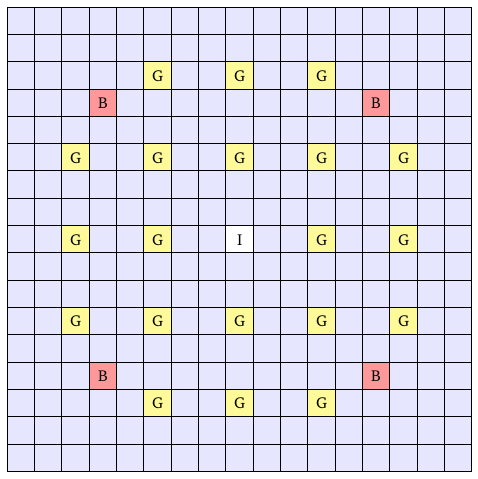

In [2]:
Image('assembly_diagram.png')

## Materials

Again we have UO<sub>2</sub>, Zr, and H<sub>2</sub>O.  We also have borosilicate glass (pyrex).  This time we'll use the shortcut for defining enriched uranium.

In [3]:
uo2 = openmc.Material(name='uo2')
uo2.add_element('U', 1.0, enrichment=3.0)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)

zirconium = openmc.Material(name='zirconium')
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(name='water')
water.add_nuclide('H1', 2)
water.add_nuclide('O16', 1)
water.set_density('g/cm3', 0.7)
water.add_s_alpha_beta('c_H_in_H2O')

pyrex = openmc.Material(name='pyrex')
pyrex.add_element('B', 0.49)
pyrex.add_element('O', 4.7)
pyrex.add_element('Al', 0.17)
pyrex.add_element('Si', 1.8)
pyrex.set_density('g/cm3', 2.26)

In [4]:
materials = openmc.Materials((uo2, zirconium, water, pyrex))
materials.export_to_xml()

Later in this example, we will make a bunch of geometry plots.  By default, every region is colored randomly and the results are Now that we know our materials, let's define a "color specification" to use when plotting our geometry.

In [5]:
colors = {
    water: 'lightblue',
    zirconium: 'gray',
    pyrex: 'green',
    uo2: 'red'
}

## Fuel pin

This is similar to the pincell example, but we don't have boundary conditions.  This `fuel_pin` universe extends to infinity

In [6]:
pitch = 1.26
fuel_or = openmc.ZCylinder(r=0.39)
clad_ir = openmc.ZCylinder(r=0.40)
clad_or = openmc.ZCylinder(r=0.46)

fuel = openmc.Cell(name='fuel', fill=uo2, region=-fuel_or)
gap = openmc.Cell(name='air gap', region=+fuel_or & -clad_ir)
clad = openmc.Cell(name='clad', fill=zirconium, region=+clad_ir & -clad_or)
moderator = openmc.Cell(name='moderator', fill=water, region=+clad_or)

fuel_pin = openmc.Universe(cells=(fuel, gap, clad, moderator))

When building a complex geometry, it is helpful to plot each universe as you go along.  Let's plot this pincell now

## Guide tube

The guide tube has the following specs:

- Clad IR = 0.56 cm
- Clad OR = 0.60 cm
- Inside the clad is water
- The clad is zirconium
- Outside the clad is water

## Pyrex burnable poison

Now you need to model the burnable poison pin. It has the following specs:

- R < 0.21 cm, void
- 0.21 cm < R < 0.23 cm, zirconium
- 0.23 cm < R < 0.24 cm, void
- 0.24 cm < R < 0.43 cm, pyrex
- 0.43 cm < R < 0.44 cm, void
- 0.44 cm < R < 0.48 cm, zirconium
- 0.48 cm < R < 0.56 cm, water
- 0.56 cm < R < 0.60 cm, zirconium
- 0.60 cm < R, water

For this, we're going to use some advanced features. First, we'll use a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions), which is a way of creating a list in Python that embeds a `for` loop.

To create this pin, we're going to use a function provided by OpenMC specifically for this purpose, `openmc.model.pin`.

## Lattices in OpenMC

OpenMC has `RectLattice` and `HexLattice` objects.  For our fuel assembly, we need to use `RectLattice`. Let's look at a simple one before we do the full assembly.

First, we also need to define a universe that is all water.

When creating a rectangular lattice, we need to define:

1. The lower-left coordinates of the lattice (`.lower_left`)
2. The size of each lattice element (`.pitch`)
3. The 2D arrangement of universes (`.universes`)
4. (_optionally_) A universe that is used outside of the defined region (`.outer`)

To plot the lattice, we need to put it in a universe. For this, we'll create a single cell filled with the lattice, and then put that single cell inside a universe to plot:

## What exactly does `outer` mean?

In the previous section, we set the lattice outer universe to a universe containing a single cell with only water in it. To get a better sense of what the outer universe does, let's change the outer universe to the guide tube universe:

## The BEAVRS assembly

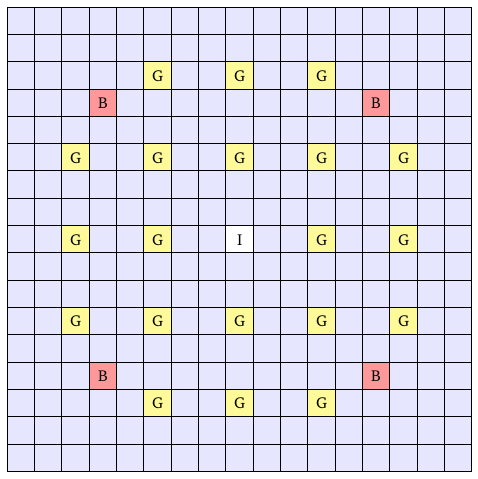

In [17]:
Image('assembly_diagram.png')

To make things a little easier, we'll create lists of (row, column) positions for the guide tubes and burnable poison rods:

In [18]:
guide_tube_positions = [
    (2, 5), (2, 8), (2, 11),
    (5, 2), (5, 5), (5, 8), (5, 11), (5, 14),
    (8, 2), (8, 5), (8, 8), (8, 11), (8, 14),
    (11, 2), (11, 5), (11, 8), (11, 11), (11, 14),
    (14, 5), (14, 8), (14, 11)
]

burn_positions = [(3, 3), (3, 13), (13, 3), (13, 13)]    

Now we just have to add the boundary conditions and root universe to finish the geometry. To create a box containing the lattice, we'll use the `rectangular_prism` function:

## Hexagonal Lattices

OpenMC also allows you to define hexagonal lattices. They are a little trickier, but as we'll see there are some helper methods that demystify how to assign universes.

We need to set the `center` of the lattice, the `pitch`, an `outer` universe (which is applied to all lattice elements outside of those that are defined), and a list of `universes`. Let's start with the easy ones first. Note that for a 2D lattice, we only need to specify a single number for the pitch.

Now we need to set the `universes` property on our lattice. It needs to be set to a list of lists of Universes, where each list of Universes corresponds to a ring of the lattice. The rings are ordered from outermost to innermost, and within each ring the indexing starts at the "top". To help visualize the proper indices, we can use the `show_indices()` helper method.

Let's set up a lattice where the first element in each ring is the guide tube universe and all other elements are regular fuel pin universes. From the diagram above, we see that the outer ring has 12 elements, the middle ring has 6, and the innermost degenerate ring has a single element.

Now let's put our lattice inside a circular cell.

### Rotating the lattice

Now let's say we want our hexagonal lattice orientated such that flat sides are parallel to the y-axis instead of the x-axis. This can be achieved by changing the orientation of the lattice from `'y'` to `'x'`:

Again, we can use the `show_indices` method to see the ordering of universes within each ring: